In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df=df=df.sort_values(by="LogP",ascending=False)
df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
694,Cc1ccc2c(-c3nnc(SCCCCN4CCc5cc6nc(C(F)(F)F)oc6c...,6.60,645.549,7.23432,0.136623
688,Cc1ccc2c(-c3nnc(SCCC(C)N4CCc5cc6nc(C(F)(F)F)oc...,5.70,645.549,7.23272,0.180539
630,COc1nc2ccc(Br)cc2cc1C(c1ccccc1)C(O)(CCN(C)C)c1...,5.80,555.516,7.13050,0.221355
712,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(C)(C)C)oc6c(...,6.40,619.633,7.12292,0.148044
752,Cc1ccccc1-c1nc2cc(-c3ccc(Cl)cc3)sc2c(=O)n1CC1C...,5.68,492.088,6.87422,0.305320
...,...,...,...,...,...
951,N#Cc1ccc(Cn2cncc2CNC2CCN(C(=O)c3ccc[nH]c3=O)C2...,4.30,416.441,1.02228,0.578476
933,N#Cc1ccc(=NC(=O)C(COCCO)Oc2ncnc3c2cnn3-c2ncccc...,4.30,480.872,0.94748,0.349009
390,CNS(=O)(=O)CCN(CCc1ccc(Cl)cc1)C1CCN(c2nc(=N)[n...,4.80,441.989,0.93337,0.461013
634,CS(=O)(=O)NCCN(CCc1ccc(Cl)cc1)C1CCN(c2nc(=N)[n...,5.14,441.989,0.93337,0.461013


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("logp_sorted_fcv_results_RF_training batches.csv", index=False)
    test_df.to_csv("logp_sorted_fcv_results_RF_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [6]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

(0.6099580540680487, 3.426260394606786e-14)
(0.509875727444057, 1.073767669485427e-09)
(0.12535800090017982, 0.16192096086766158)
(0.707750356034285, 1.9416135391630775e-20)
(0.8082345566116764, 2.670312990665134e-30)
(0.83200613075105, 1.5935649573245074e-33)
(0.8857284677016777, 3.784236104163334e-43)
(0.9090457914178535, 5.6581384221331956e-49)
(0.44229592626666425, 1.722089351446928e-07)


In [7]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(10, 3)
(10, 3)
(8, 3)
(10, 3)
(4, 3)
(15, 3)
(20, 3)
(41, 3)
(38, 3)


In [8]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(5, 3)
(5, 3)
(2, 3)
(2, 3)
(1, 3)
(4, 3)
(4, 3)
(9, 3)
(7, 3)


In [9]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(11, 3)
(27, 3)
(16, 3)
(33, 3)
(40, 3)
(35, 3)
(42, 3)
(26, 3)
(42, 3)


In [10]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(99, 3)
(82, 3)
(98, 3)
(75, 3)
(76, 3)
(70, 3)
(59, 3)
(49, 3)
(38, 3)


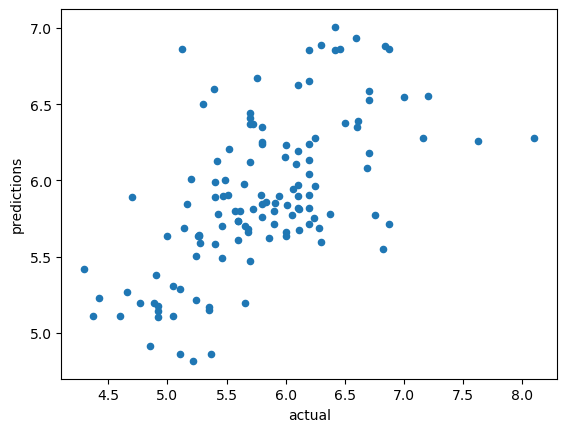

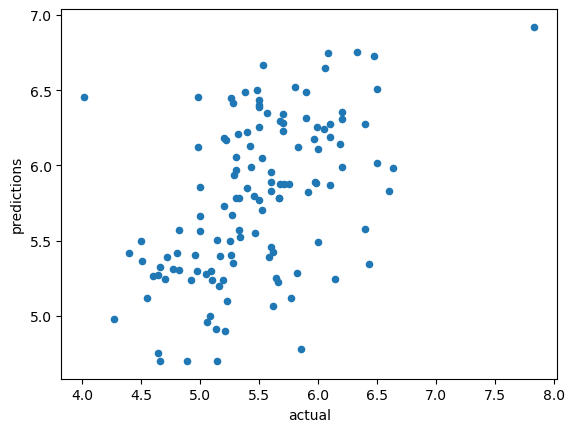

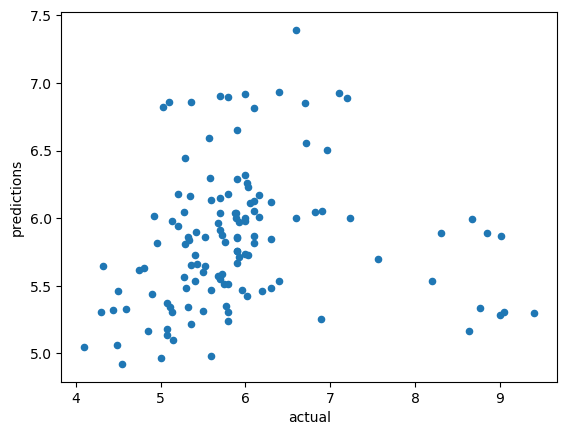

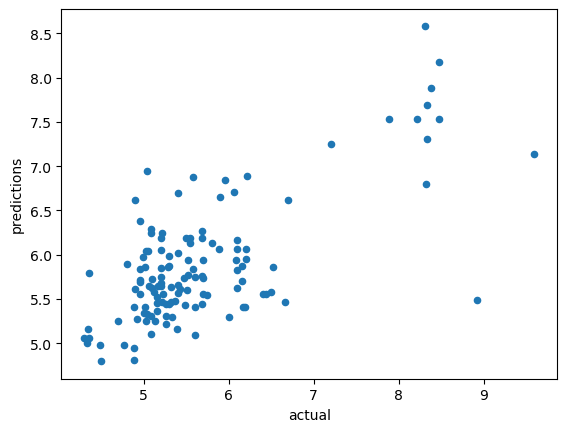

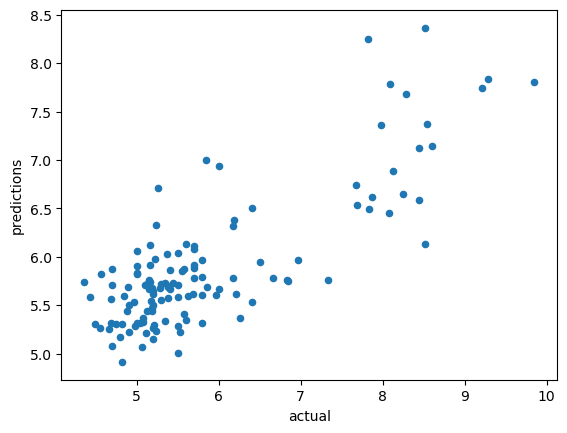

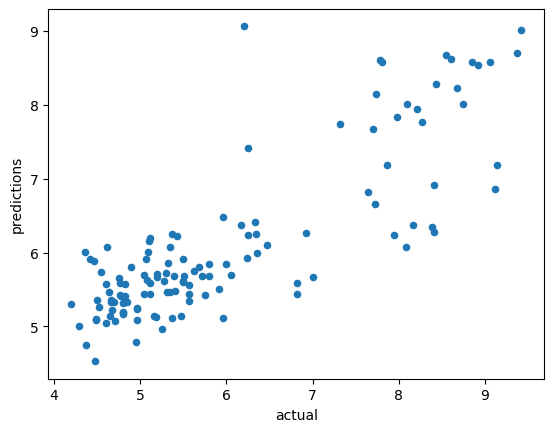

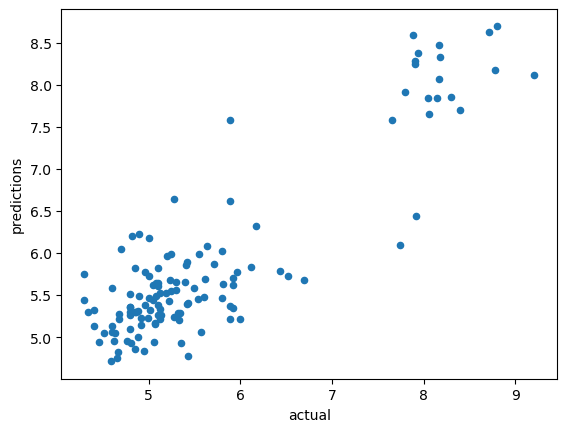

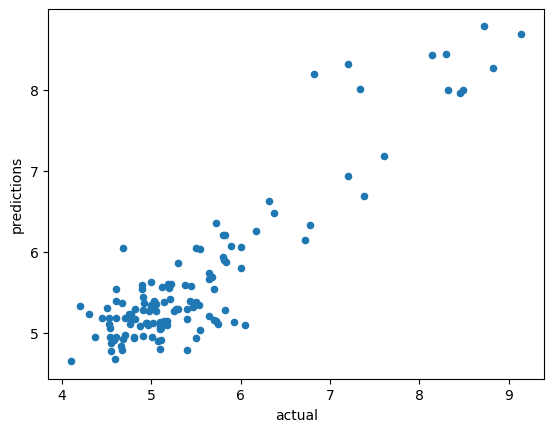

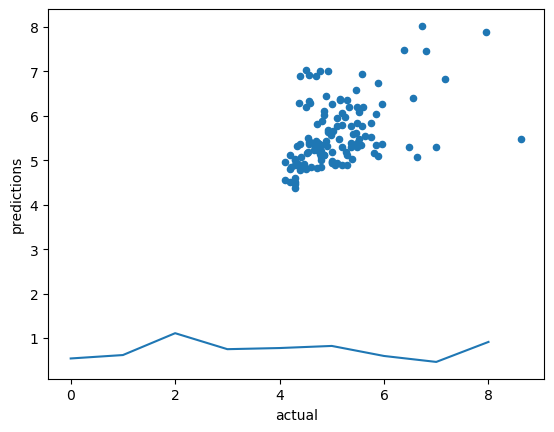

[0.5422610428266934, 0.6192249253328888, 1.1105810966842358, 0.751110638584266, 0.7768103314909706, 0.8239862134769005, 0.5984145454899709, 0.4646142926690708, 0.9143410535393782]


In [11]:
plt.plot(rmse)
plt.show()
print(rmse)

In [12]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

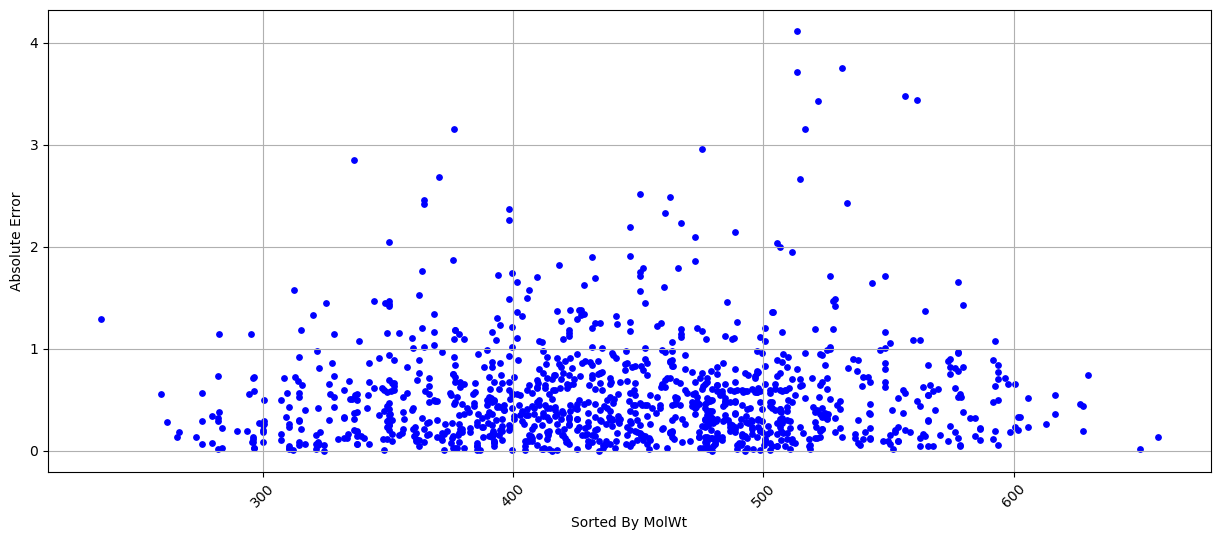

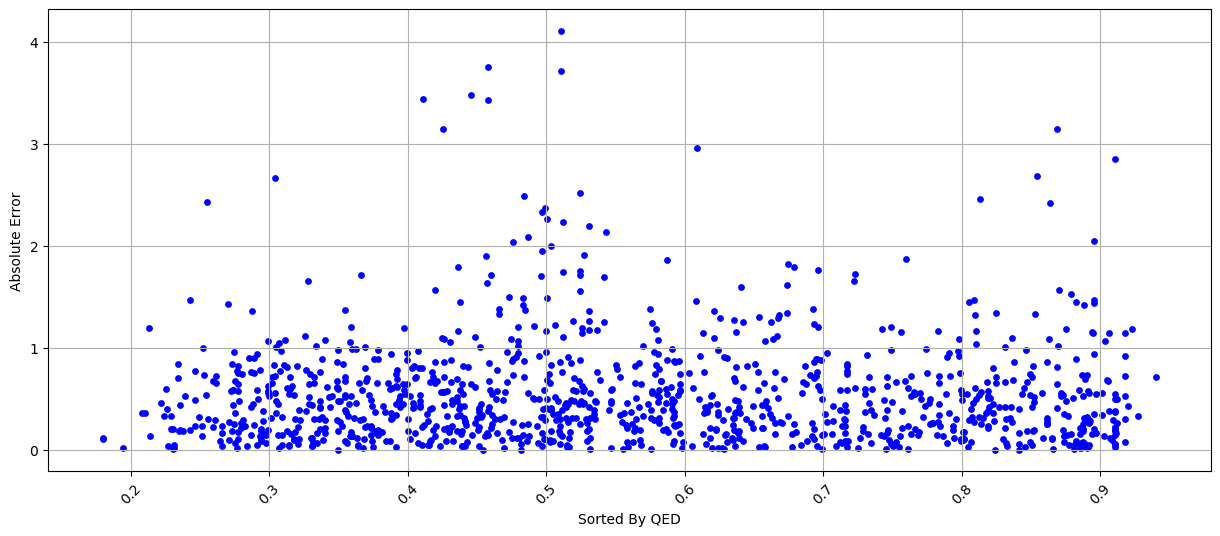

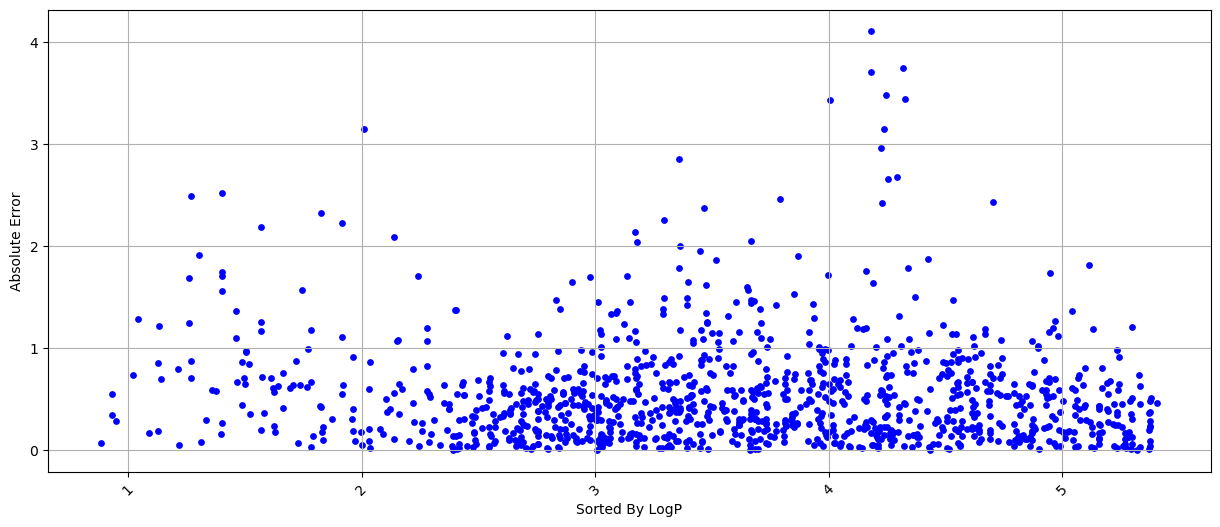

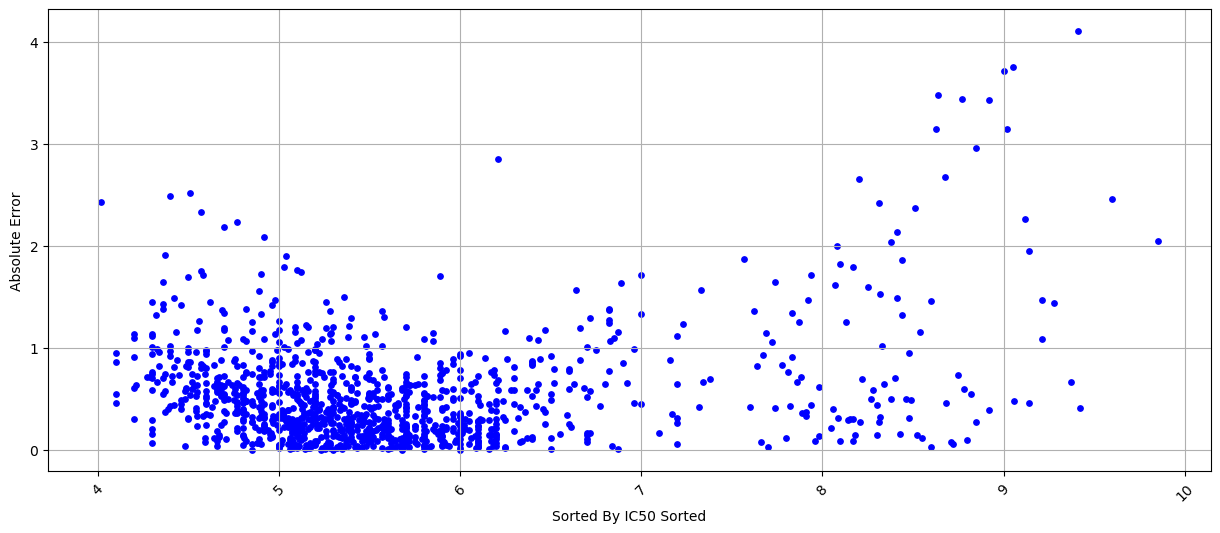

In [13]:
plot_graphs(df, results_df)

In [14]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
694,Cc1ccc2c(-c3nnc(SCCCCN4CCc5cc6nc(C(F)(F)F)oc6c...,6.60,645.549,7.23432,0.136623,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
688,Cc1ccc2c(-c3nnc(SCCC(C)N4CCc5cc6nc(C(F)(F)F)oc...,5.70,645.549,7.23272,0.180539,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
630,COc1nc2ccc(Br)cc2cc1C(c1ccccc1)C(O)(CCN(C)C)c1...,5.80,555.516,7.13050,0.221355,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
712,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(C)(C)C)oc6c(...,6.40,619.633,7.12292,0.148044,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
752,Cc1ccccc1-c1nc2cc(-c3ccc(Cl)cc3)sc2c(=O)n1CC1C...,5.68,492.088,6.87422,0.305320,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
951,N#Cc1ccc(Cn2cncc2CNC2CCN(C(=O)c3ccc[nH]c3=O)C2...,4.30,416.441,1.02228,0.578476,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
933,N#Cc1ccc(=NC(=O)C(COCCO)Oc2ncnc3c2cnn3-c2ncccc...,4.30,480.872,0.94748,0.349009,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
390,CNS(=O)(=O)CCN(CCc1ccc(Cl)cc1)C1CCN(c2nc(=N)[n...,4.80,441.989,0.93337,0.461013,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
634,CS(=O)(=O)NCCN(CCc1ccc(Cl)cc1)C1CCN(c2nc(=N)[n...,5.14,441.989,0.93337,0.461013,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        X_test = X[(len(X)-fold_size):(len(X))]
        y_test = y[(len(X)-fold_size):(len(X))]
        smiles_test = smiles[(len(X)-fold_size):(len(X))] 
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("logp_sorted_fcv_results_RF_training batches_druglike.csv", index=False)
    test_df.to_csv("logp_sorted_fcv_results_RF_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [16]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X, y, smiles, sort_by=None, additional_info=df["QED"])

(0.01808294804946181, 0.8407188506405645)
(0.017418627928543776, 0.8464971908487653)
(-0.1492623713849138, 0.09529064517933863)
(0.07293038596136361, 0.41704168721096413)
(0.331320610472776, 0.0001508827034706884)
(0.4284604719100946, 5.584169193107287e-07)
(0.5300880040601952, 1.733924997017437e-10)
(0.4515220549435199, 1.1169828022188873e-07)
(0.4470870608155795, 1.5363585674333798e-07)


In [17]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(0, 3)
(0, 3)
(3, 3)
(0, 3)
(5, 3)
(16, 3)
(25, 3)
(36, 3)
(38, 3)


In [18]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(1, 3)
(1, 3)
(0, 3)
(0, 3)
(6, 3)
(6, 3)


In [19]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(43, 3)
(43, 3)
(43, 3)
(42, 3)
(42, 3)
(43, 3)
(43, 3)
(37, 3)
(37, 3)


In [20]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(80, 3)
(80, 3)
(77, 3)
(80, 3)
(75, 3)
(64, 3)
(55, 3)
(44, 3)
(42, 3)


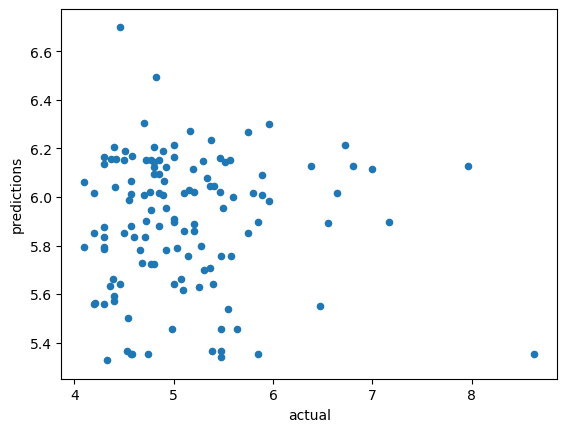

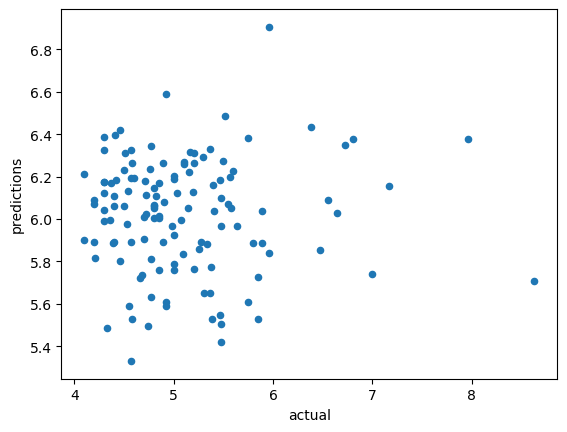

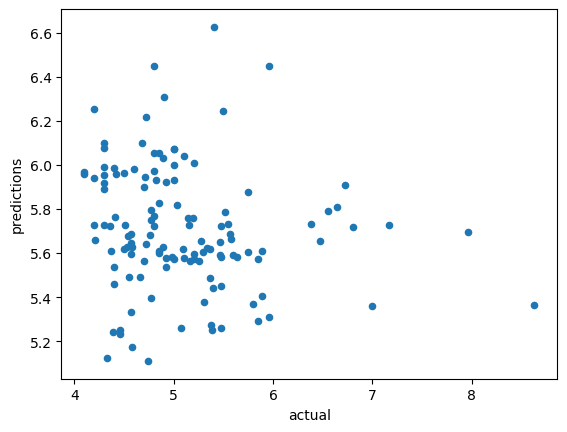

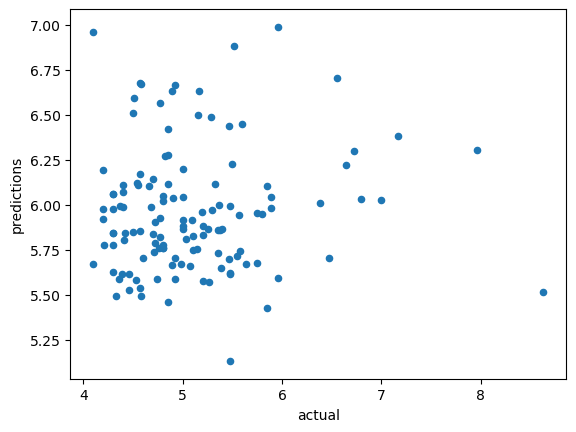

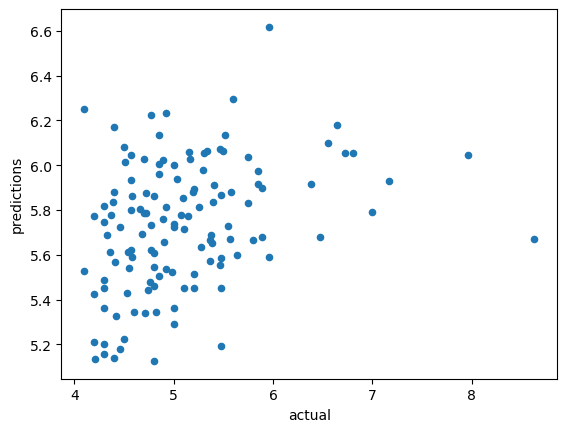

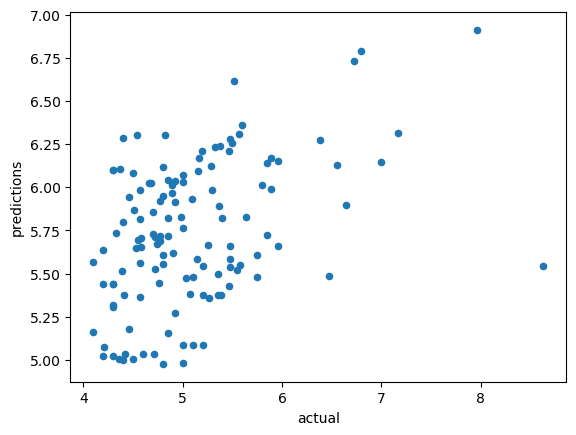

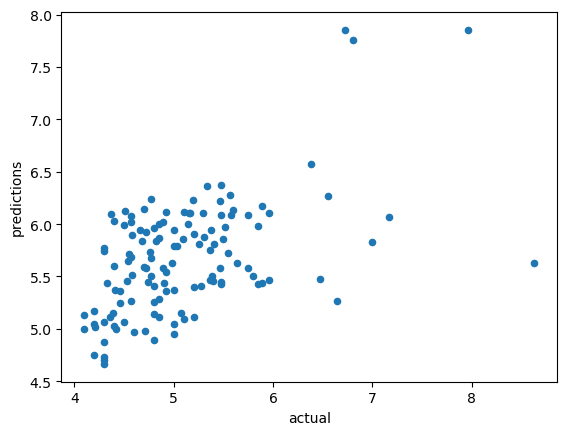

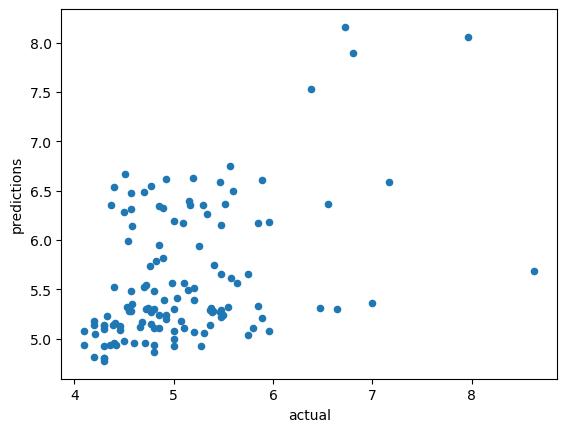

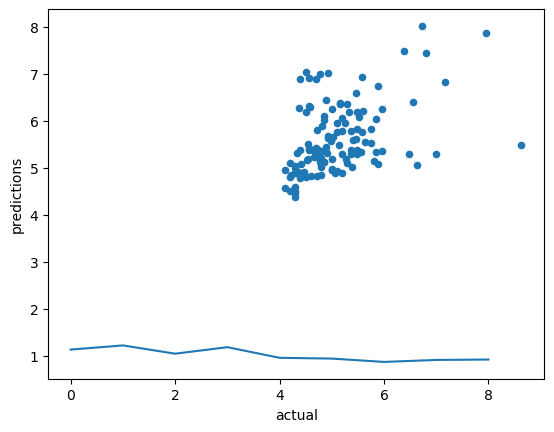

[1.1328269929399457, 1.2212277062919428, 1.0454433354213113, 1.1838641583746259, 0.9578362097780103, 0.9410562655445392, 0.8701807223351995, 0.9122305241584219, 0.9208569437179971]


In [21]:
plt.plot(rmse)
plt.show()
print(rmse)